## Imports

In [22]:
import os
import numpy as np
import pennylane as qml
import matplotlib.pyplot as plt

In [4]:
from create_noise_models import noisy_dev_from_backend
from create_gate_circs import create_batched_gate_circ, get_circ_params, generate_true_random_gate_circ
from metrics import compute_noise_metric

## Generate some circuits to compute the noise metric for

In [7]:
num_qubits = 4
num_embeds = 0 # do not need to worry about dataset, so no data embeddings required
num_circs_to_generate = 25 # number of circuits to generate

store_dir = './noise_metric_circuits' # folder you want to store all the circuits in

if not os.path.exists(store_dir):
    os.mkdir(store_dir)

for i in range(25):
    curr_circ_dir = os.path.join(store_dir, f'circ_{i + 1}')
        
    if not os.path.exists(curr_circ_dir):
        os.mkdir(curr_circ_dir)
        
    ent_prob = np.random.sample() # probability / proportion of 2-qubit gates in circuit
    cxz = np.random.sample() # proportion of 2-qubit gates that are cx / cz gates
    pauli = 0 # proportion of 2-qubit gates that are XX / YY / ZZ gates
    
    num_params = np.random.randint(5, 10) # you can change this if you want to

    circ_gates, gate_params, inputs_bounds, weights_bounds = generate_true_random_gate_circ(num_qubits, num_embeds, num_params, 
                                                                                            ent_prob=ent_prob, 
                                                                                            cxz_prob=cxz * ent_prob,
                                                                                            pauli_prob=pauli * (1 - cxz) * ent_prob)

    # save circuit information in text files
    
    np.savetxt(curr_circ_dir + '/gates.txt', circ_gates, fmt="%s")
    np.savetxt(curr_circ_dir + '/gate_params.txt', gate_params, fmt="%s")
    np.savetxt(curr_circ_dir + '/inputs_bounds.txt', inputs_bounds)
    np.savetxt(curr_circ_dir + '/weights_bounds.txt', weights_bounds)

## Compute noise metric for generated circuits (takes ~ 30s per circuit to run)

In [ ]:
circuit_dir = './noise_metric_circuits' # overwrite if you have to

num_qubits = 4
num_trial_params = 128 # number of circuit runs used to compute actual circuit fidelity
meas_qubits = [i for i in range(num_qubits)]
num_cdcs = 128 # number of clifford decoy circuits to use
num_shots = 1024 # number of shots to use when running clifford decoy circuits and actual parametrized circuits
num_circs = 25 # depends on how many you generated

device_name = 'ibm_oslo' # only choose publicly available devices
dev = noisy_dev_from_backend(device_name, num_qubits) # create pennylane device using nosie model of chosen device
noiseless_dev = qml.device('lightning.qubit', wires=num_qubits) # noiseless device for reference

clifford_tvds = []
actual_tvds = []


for i in range(2):
    curr_circ_dir = os.path.join(circuit_dir, f'circ_{i + 1}')

    # get the circuit gates, etc. of the current circuit
    circ_gates, gate_params, inputs_bounds, weights_bounds = get_circ_params(curr_circ_dir) 

    # create circuits that you can pass batched inputs and parameters through using pennylane
    
    noisy_circ = create_batched_gate_circ(dev, circ_gates, gate_params, inputs_bounds,
                                                                    weights_bounds, meas_qubits, 'probs') 

    noiseless_circ = create_batched_gate_circ(noiseless_dev, circ_gates, gate_params, inputs_bounds,
                                                                    weights_bounds, meas_qubits, 'probs') 

    # where to store noise metric information of the circuit
    noise_metric_dir = os.path.join(curr_circ_dir, 'noise_metric') 

    if not os.path.exists(noise_metric_dir):
        os.mkdir(noise_metric_dir)

    # where to store information about the noise metric for this specific device
    device_noise_metric_dir = os.path.join(noise_metric_dir, device_name) 

    if not os.path.exists(device_noise_metric_dir):
        os.mkdir(device_noise_metric_dir)

    # randomly generate some parameter values to use
    params = np.random.sample((num_trial_params, weights_bounds[-1])) * 2 * np.pi
    
    # empty, since we do not use any data to compute the noise metric (but we can if we want to)
    batch_data = []

    # get the noiseless and noisy output probability distributions for the actual parametrized circuit runs
    
    noiseless_res_raw = np.array(noiseless_circ(batch_data, params, shots=num_shots))
    noisy_res_raw = np.array(noisy_circ(batch_data, params, shots=num_shots))

    # compute the TVD using the outputs
    actual_tvd = 1 - np.mean(np.sum(0.5 * np.abs(noiseless_res_raw - noisy_res_raw), 1))
        
    # Now get the TVD using the clifford decoy circuits
    clifford_tvd = 1 - compute_noise_metric(circ_gates, gate_params, inputs_bounds, weights_bounds, num_qubits, noiseless_dev, dev, num_cdcs=num_cdcs, num_shots=num_shots)

    # save the results
    np.savetxt(device_noise_metric_dir + '/metric_tvd_score.txt', [clifford_tvd])
    np.savetxt(device_noise_metric_dir + '/actual_tvd_score.txt', [actual_tvd])

    clifford_tvds.append(clifford_tvd)
    actual_tvds.append(actual_tvd)

    print(f'Circuit {i + 1}: Actual Fidelity: {actual_tvd} | Clifford Fidelity: {clifford_tvd}')
        
np.savetxt(os.path.join(circuit_dir, f'act_tvds_{device_name}.txt'), actual_tvds)
np.savetxt(os.path.join(circuit_dir, f'clifford_tvds_{device_name}.txt'), clifford_tvds)

## Plot data

Text(0, 0.5, 'Actual Circuit Fidelity')

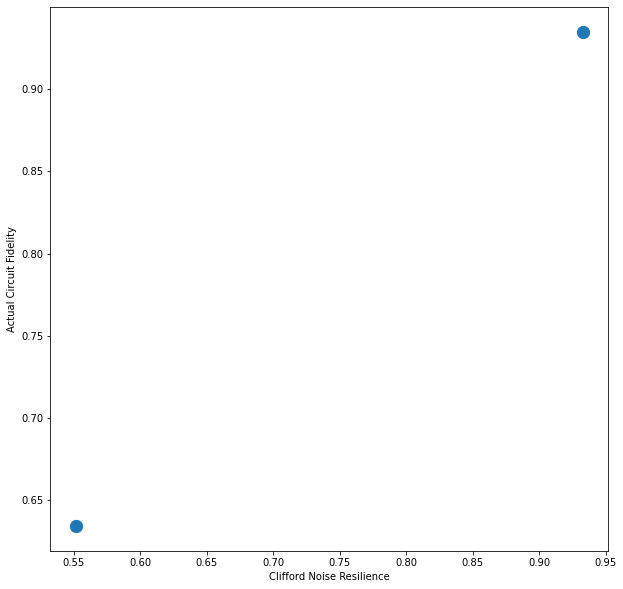

In [24]:
results_dir = './noise_metric_circuits' # same folder you stored the circuits in
device_name = 'ibm_oslo' # same device you used the noise model of to compute the fidelities

clifford_tvds = np.genfromtxt(os.path.join(results_dir, f'clifford_tvds_{device_name}.txt'))
actual_tvds = np.genfromtxt(os.path.join(results_dir, f'act_tvds_{device_name}.txt'))

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.scatter(clifford_tvds, actual_tvds, s=150)
ax.set_xlabel('Clifford Noise Resilience')
ax.set_ylabel('Actual Circuit Fidelity')